# Twitter Sentiment Analysis

In [ ]:
!nvidia-smi

Mon May  2 08:47:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gensim==3.6.0
!pip install keras --upgrade
!pip install pandas --upgrade

In [ ]:
# DataFrame
import pandas as pd
import keras

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [ ]:
# DATASET
dataset_columns = ["target", "ids", "date", "flag", "user", "text"]
dataset_encoding = "ISO-8859-1"
train_size = 0.8

# TEXT CLENAING
RE_exp = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
w2v_size = 300
w2v_window = 7
w2v_epoch = 32
w2v_min_count = 10

# KERAS
seq_len = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
sent_thres = (0.4, 0.7)

### Read Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/MyDrive/sentiment.csv"
df = pd.read_csv(dataset_path, encoding = dataset_encoding , names = dataset_columns)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 423 ms, sys: 6.17 ms, total: 429 ms
Wall time: 422 ms


### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(RE_exp, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 56.2 s, sys: 278 ms, total: 56.5 s
Wall time: 56.9 s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-train_size, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.89 s, sys: 367 ms, total: 3.26 s
Wall time: 3.24 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_size, 
                                            window=w2v_window, 
                                            min_count=w2v_min_count, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2022-05-01 05:46:15,984 : INFO : collecting all words and their counts
2022-05-01 05:46:15,985 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-01 05:46:16,004 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-05-01 05:46:16,023 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-05-01 05:46:16,041 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-05-01 05:46:16,062 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-05-01 05:46:16,080 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-05-01 05:46:16,100 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-05-01 05:46:16,121 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-05-01 05:46:16,140 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=w2v_epoch)

2022-05-01 05:46:30,319 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-05-01 05:46:31,335 : INFO : EPOCH 1 - PROGRESS: at 9.45% examples, 771891 words/s, in_qsize 16, out_qsize 0
2022-05-01 05:46:32,352 : INFO : EPOCH 1 - PROGRESS: at 19.19% examples, 779834 words/s, in_qsize 15, out_qsize 0
2022-05-01 05:46:33,355 : INFO : EPOCH 1 - PROGRESS: at 29.26% examples, 795384 words/s, in_qsize 14, out_qsize 1
2022-05-01 05:46:34,360 : INFO : EPOCH 1 - PROGRESS: at 36.51% examples, 745026 words/s, in_qsize 11, out_qsize 4
2022-05-01 05:46:35,364 : INFO : EPOCH 1 - PROGRESS: at 45.16% examples, 738041 words/s, in_qsize 15, out_qsize 1
2022-05-01 05:46:36,424 : INFO : EPOCH 1 - PROGRESS: at 53.27% examples, 719329 words/s, in_qsize 14, out_qsize 1
2022-05-01 05:46:37,430 : INFO : EPOCH 1 - PROGRESS: at 61.82% examples, 716524 words/s, in_qsize 15, out_qsize 0
2022-05-01 05:46:38,433 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 19min 8s, sys: 5.67 s, total: 19min 13s
Wall time: 5min 24s


(263126189, 295270528)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-05-01 05:51:54,802 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5801413059234619),
 ('loved', 0.5415389537811279),
 ('loves', 0.5400099158287048),
 ('adore', 0.5304422974586487),
 ('amazing', 0.5103352069854736),
 ('looove', 0.48566293716430664),
 ('awesome', 0.4705257713794708),
 ('loveee', 0.43806278705596924),
 ('loooove', 0.43743059039115906),
 ('lovee', 0.4364038407802582)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 15.5 s, sys: 19.5 ms, total: 15.5 s
Wall time: 15.5 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=seq_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=seq_len)

CPU times: user 22.1 s, sys: 377 ms, total: 22.5 s
Wall time: 22.4 s


### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, w2v_size))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, w2v_size, weights=[embedding_matrix], input_length=seq_len, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-05-01 05:52:36,806 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 600s 533ms/step - loss: 0.4765 - accuracy: 0.7688 - val_loss: 0.4559 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 581s 516ms/step - loss: 0.4706 - accuracy: 0.7728 - val_loss: 0.4545 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4669 - accuracy: 0.7750 - val_loss: 0.4505 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 573s 509ms/step - loss: 0.4646 - accuracy: 0.7764 - val_loss: 0.4482 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 576s 512ms/step - loss: 0.4628 - accuracy: 0.7777 - val_loss: 0.4465 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4613 - accuracy: 0.7782 - val_loss: 0.4479 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 7/8
1125/1125 [===================

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 34s 106ms/step - loss: 0.4435 - accuracy: 0.7928

ACCURACY: 0.792759358882904
LOSS: 0.443481981754303
CPU times: user 30.8 s, sys: 1.3 s, total: 32.2 s
Wall time: 33.8 s


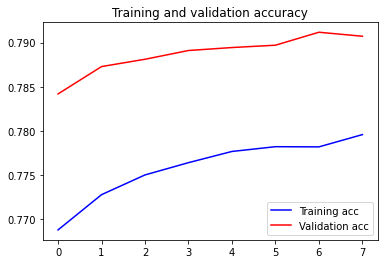

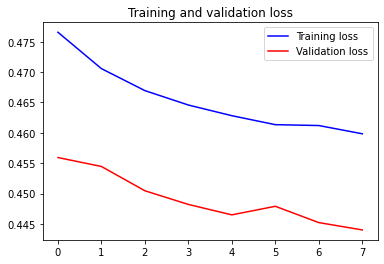

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= sent_thres[0]:
            label = NEGATIVE
        elif score >= sent_thres[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=seq_len)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.33767175674438477,
 'label': 'POSITIVE',
 'score': 0.9717611074447632}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.11081647872924805,
 'label': 'NEGATIVE',
 'score': 0.01091895904392004}

In [ ]:
predict("I am weirded out")

{'elapsed_time': 0.11071562767028809,
 'label': 'NEUTRAL',
 'score': 0.5083423852920532}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 22s 541ms/step
CPU times: user 13.4 s, sys: 9.77 s, total: 23.2 s
Wall time: 22.5 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

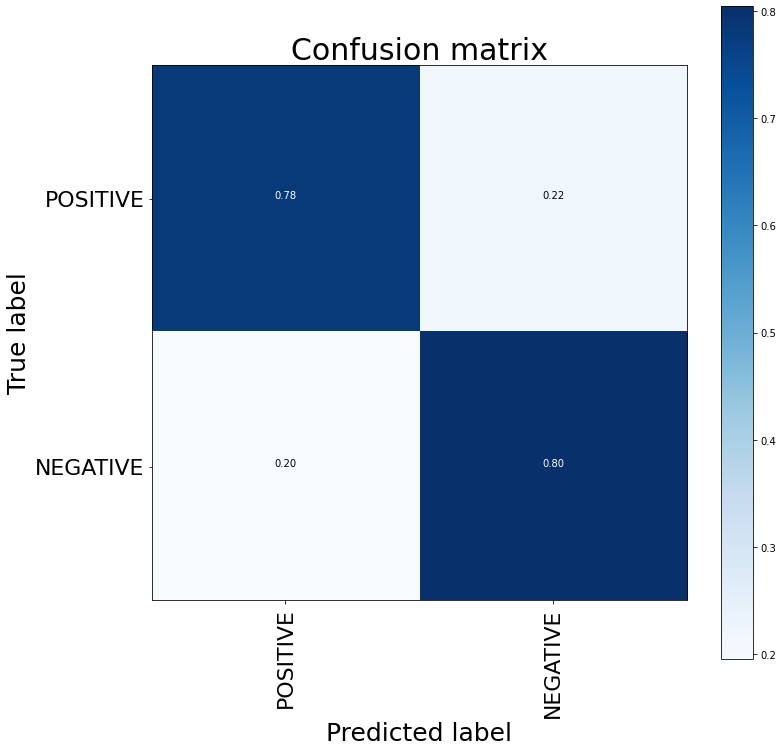

CPU times: user 1.15 s, sys: 15.9 ms, total: 1.16 s
Wall time: 1.16 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.792759375

### Save model

In [ ]:
KERAS_MODEL = "/content/gdrive/MyDrive/model.h5"
WORD2VEC_MODEL = "/content/gdrive/MyDrive/model.w2v"
TOKENIZER_MODEL = "/content/gdrive/MyDrive/tokenizer.pkl"
ENCODER_MODEL = "/content/gdrive/MyDrive/encoder.pkl"

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-05-01 07:31:54,150 : INFO : saving Word2Vec object under /content/gdrive/MyDrive/model.w2v, separately None
2022-05-01 07:31:54,152 : INFO : not storing attribute vectors_norm
2022-05-01 07:31:54,156 : INFO : not storing attribute cum_table
2022-05-01 07:31:54,956 : INFO : saved /content/gdrive/MyDrive/model.w2v


In [ ]:
tokenizer = Tokenizer()
encoder = LabelEncoder()

In [ ]:
w2v_model = gensim.models.Word2Vec.load("/content/gdrive/MyDrive/model.w2v")
tokenizer = pickle.load(open(TOKENIZER_MODEL, "rb"))
encoder = pickle.load(open(ENCODER_MODEL, "rb"))
model = keras.models.load_model('/content/gdrive/MyDrive/model.h5')

2022-05-02 08:48:42,877 : INFO : loading Word2Vec object from /content/gdrive/MyDrive/model.w2v
2022-05-02 08:48:45,161 : INFO : loading wv recursively from /content/gdrive/MyDrive/model.w2v.wv.* with mmap=None
2022-05-02 08:48:45,163 : INFO : setting ignored attribute vectors_norm to None
2022-05-02 08:48:45,164 : INFO : loading vocabulary recursively from /content/gdrive/MyDrive/model.w2v.vocabulary.* with mmap=None
2022-05-02 08:48:45,169 : INFO : loading trainables recursively from /content/gdrive/MyDrive/model.w2v.trainables.* with mmap=None
2022-05-02 08:48:45,169 : INFO : setting ignored attribute cum_table to None
2022-05-02 08:48:45,170 : INFO : loaded /content/gdrive/MyDrive/model.w2v


2022-05-02 08:48:50,996 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [ ]:
predict("I love the music")

{'elapsed_time': 0.1055293083190918,
 'label': 'POSITIVE',
 'score': 0.9717611074447632}